# Importing Packages & Set Up Data Layout

## Preprocessing Information for the Given Data.

A high-pass filter with a 30 Hz cut-off frequency and a power line notch filter (50 Hz) were used. All recordings are artifact-free EEG segments of 60 seconds duration. At the stage of data preprocessing, the Independent Component Analysis (ICA) was used to eliminate the artifacts (eyes, muscle, and cardiac overlapping of the cardiac pulsation). The arithmetic task was the serial subtraction of two numbers. Each trial started with the communication orally 4-digit (minuend) and 2-digit (subtrahend) numbers (e.g. 3141 and 42).

In [1]:
# Let's load some packages we need (pip install mne)
import mne
import mne.viz
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# ! pip install mne

# Read raw data files where each file contains a run
files = ['../../datasets/HW2Datasets/Subject06_1.edf', '../../datasets/HW2Datasets/Subject06_2.edf', '../../datasets/HW2Datasets/Subject07_1.edf', '../../datasets/HW2Datasets/Subject07_2.edf']

# Read the raw EDF files into an array
raws = [read_raw_edf(f, preload=True) for f in files]

# Loop through the array and make the following changes to the raw files
for raw in raws:

    # Rename the raw channels
    raw.rename_channels({'EEG F3':'F3', 'EEG F4':'F4',
                            'EEG Fp1':'Fp1', 'EEG Fp2':'Fp2', 'EEG F7':'F7', 'EEG F8':'F8',
                            'EEG T3':'T3', 'EEG T4':'T4', 'EEG C3':'C3', 'EEG C4':'C4',
                            'EEG T5':'T5', 'EEG T6':'T6', 'EEG P3':'P3', 'EEG P4':'P4',
                            'EEG O1':'O1', 'EEG O2':'O2', 'EEG Fz':'Fz', 'EEG Cz':'Cz',
                            'EEG Pz':'Pz', 'EEG A2-A1':'A2', 'ECG ECG':'ECG'})


    # Set channel types
    raw.set_channel_types({'ECG':'ecg'})

    # Define the channel locations
    raw.set_montage(mne.channels.make_standard_montage('standard_1020'))

    # Print Raw Channel Names for double checking
    print(raw.ch_names)

# Rename the raws with more insightfull names
subject6_background = raws[0] # Subject 6 background raw
subject6_task = raws[1] # Subject 6 task raw
subject7_background = raws[2] # Subject 7 background raw
subject7_task = raws[3] # Subject 7 task raw

# Function to segment data into non-overlapping windows of length 300 samples
def segment_data(raw, window_size=300):
    data = raw.get_data()  # Get the raw data
    n_channels, n_samples = data.shape # get dimensions
    print("Data Shape Before:", n_channels, n_samples) # display dimensions for understanding
    n_windows = n_samples // window_size  # Number of windows

    # Reshape data into (n_channels, n_windows, window_size)
    segmented_data = data[:, :n_windows * window_size].reshape(n_channels, n_windows, window_size)
    print("Data Shape After:", n_channels, n_windows, window_size) # display shape after reshaping

    return segmented_data # return the segmented data


# Segment each raw file into windows
subject6_background_segments = segment_data(subject6_background)
subject6_task_segments = segment_data(subject6_task)
subject7_background_segments = segment_data(subject7_background)
subject7_task_segments = segment_data(subject7_task)

# Create labels: 0 for background, 1 for task
subject6_background_labels = np.zeros(subject6_background_segments.shape[1])
subject6_task_labels = np.ones(subject6_task_segments.shape[1])
subject7_background_labels = np.zeros(subject7_background_segments.shape[1])
subject7_task_labels = np.ones(subject7_task_segments.shape[1])

# Concatenate data for both subjects
X = np.concatenate([subject6_background_segments, subject6_task_segments, 
                    subject7_background_segments, subject7_task_segments], axis=1)

# Concatenate labels for both subjects
y = np.concatenate([subject6_background_labels, subject6_task_labels,
                    subject7_background_labels, subject7_task_labels])

# Reshape the data for model training (n_samples, n_features)
X = X.reshape(X.shape[1], -1)  # (n_windows, n_channels * window_size)

# X shape will be (n_channels, total_windows * window_size), and y will be the labels for each window
print("Shape of segmented data:", X.shape) # See the dimensions of X
print("Shape of labels:", y.shape) # See the dimensions of y

Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/HW2Datasets/Subject06_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/HW2Datasets/Subject06_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/HW2Datasets/Subject07_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/HW2Datasets/Subject07_2.edf...
EDF file de

# Q2) 
## Repeat the analysis in (Q1) using the 5-fold cross validation technique. Compare the results with the previous case and provide detailed explanation of potential causes of these differences.

Previously...

In [2]:
# Import ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score


# Split the dataset into 50% train and 50% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
print("Total Number of Train Values", len(y_train)) # See number of trained values
print("Total Number of y=1 Train Values", sum(y_train)) # See number of y=1 values

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)

# Evaluate the model using balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Evaluate the model using f1 score
f1 = f1_score(y_test, y_pred)

# Print accuracy
print(f"Accuracy: {accuracy*100:.2f}%")

# Print balanced accuracy
print(f"Balanced Accuracy: {balanced_accuracy*100:.2f}%")

# Print f1 score
print(f"F1 Score: {f1*100:.2f}%")

Total Number of Train Values 406
Total Number of y=1 Train Values 100.0
Accuracy: 73.89%
Balanced Accuracy: 50.00%
F1 Score: 0.00%


Last Question (Q1) I talked in detail why this model sucks & explained what each of the evaluation metrics mean.

This time we will do the same procedure as above, but using k-folds with k=5. This will allow us to have 5 different training and evaluating pools which could lead to different results.

In [3]:
# Import library for k-folds
from sklearn.model_selection import StratifiedKFold

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Create k-folds where k=5
skf = StratifiedKFold(n_splits=5)
folds = skf.split(X, y) # make different folds for X and y

train_idxs=[] # store training indexes
test_idxs=[] # store test indexes
total_y_test = [] # store all y test values
total_y_pred = [] # store all y pred values

# Loop through all folds
for i, fold in enumerate(folds):
    train_idx, test_idx = fold # Grab indexes from fold
    train_idxs.append(train_idx) # append training indexes to the training list
    test_idxs.append(test_idx) # append testing indexes to the testing list

# Loop through the 5 folds made previously
for i in range(5):
    X_train = X[train_idxs[i][:]] # Load in the training X values from index i
    y_train = y[train_idxs[i][:]] # Load in the training y values from index i
    X_test = X[test_idxs[i][:]] # Load in the testing X values from index i
    y_test = y[test_idxs[i][:]] # Load in the testing y values from index i

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Extend total y test array
    total_y_test.extend(y_test)

    # Extend total y pred array
    total_y_pred.extend(y_pred)

    # Print out the current fold we are itterating over
    print("Examining fold %i" % (i + 1))

    # Evaluate the model using accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Evaluate the model using balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Evaluate the model using f1 score
    f1 = f1_score(y_test, y_pred)

    # Print accuracy
    print(f"Accuracy: {accuracy*100:.2f}%")

    # Print balanced accuracy
    print(f"Balanced Accuracy: {balanced_accuracy*100:.2f}%")

    # Print f1 score
    print(f"F1 Score: {f1*100:.2f}%\n")

Examining fold 1
Accuracy: 74.85%
Balanced Accuracy: 50.00%
F1 Score: 0.00%

Examining fold 2
Accuracy: 74.23%
Balanced Accuracy: 50.00%
F1 Score: 0.00%

Examining fold 3
Accuracy: 74.69%
Balanced Accuracy: 50.00%
F1 Score: 0.00%

Examining fold 4
Accuracy: 74.69%
Balanced Accuracy: 50.00%
F1 Score: 0.00%

Examining fold 5
Accuracy: 74.69%
Balanced Accuracy: 50.00%
F1 Score: 0.00%



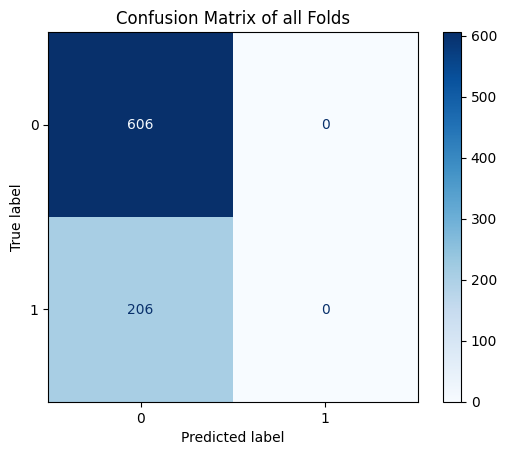

True Negatives (TN): 606
False Positives (FP): 0
False Negatives (FN): 206
True Positives (TP): 0


In [6]:
# Import library for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(total_y_test, total_y_pred)

# Construct the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)  # plot the matrix
plt.title("Confusion Matrix of all Folds") # title matrix
plt.show() # show matrix

# Get the confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}") # Show the Number of True Negatives
print(f"False Positives (FP): {fp}") # Show the Number of False Positives
print(f"False Negatives (FN): {fn}") # Show the Number of False Negatives
print(f"True Positives (TP): {tp}") # Show the Number of True Positives 

Here we can see that the F1 Score is still 0% and the Balanced Accuracy is still 50% which tells us that our model given different training data in terms of being divided into k-folds is not statisfactory enough change in order to make the model work as intended. That intended thing being that the model can accurately predict if brain signals are associated with a task as well as a background, not just background which the model is doing here just as it was doing before.

Also the Accuracy metric is changing throughout the folds sometimes and the reason for that is because the accuracy metric is more sensitive to little changes in the data (one more y=0 improves score) in comparision to the other metrics in this circumstance (in F1 Score & Balanced Accuracy, more y=0 will never improve this score because the other term is 0, removing the chances for any improvement).

Overall these metric results given with k-folds are almost the same as the results given in Q1. F1 Score is the same, Balanced Accuracy is the same, and Accuracy is 1% different given the fold itteration, but mostly the same too.